# Empirical PDF functions

How to calculate the PDF, CDF and SF from empirical data.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

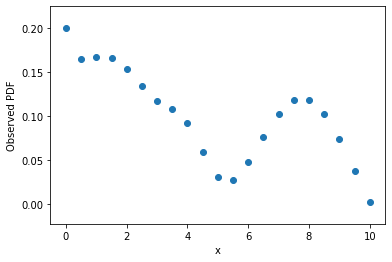

In [3]:
xs = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 
      5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0]
ys = [0.2, 0.165, 0.167, 0.166, 0.154, 0.134, 0.117, 
      0.108, 0.092, 0.06, 0.031, 0.028, 0.048, 0.077, 
      0.103, 0.119, 0.119, 0.103, 0.074, 0.038, 0.003]

plt.scatter(xs, ys)
plt.xlabel("x")
plt.ylabel("Observed PDF");

Assuming this is a continuous function with only sparse observations. So how can we fill in the blanks?

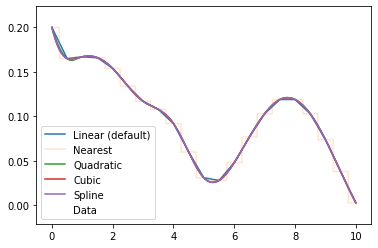

In [4]:
x = np.linspace(min(xs), max(xs), 1000)
y1 = interp1d(xs, ys)(x)
y2 = interp1d(xs, ys, kind="nearest")(x)
y3 = interp1d(xs, ys, kind="quadratic")(x)
y4 = interp1d(xs, ys, kind="cubic")(x)

from scipy.interpolate import splev, splrep
y5 = splev(x, splrep(xs, ys))

plt.scatter(xs, ys, s=30, label="Data", c="w")
plt.plot(x, y1, label="Linear (default)")
plt.plot(x, y2, label="Nearest", alpha=0.2)
plt.plot(x, y3, label="Quadratic", ls='-')
plt.plot(x, y4, label="Cubic", ls='-')
plt.plot(x, y5, label="Spline", ls='-', alpha=1)
plt.legend();

Using the `interp1d` we can now find a probability value for any `x` value.

How can we calculate the CDF and the probability we would find a value between two bounds? Using `scipy.integrate`. Scipy to the rescue once again!

We have many options:

* `scipy.integrate.trapz` for low accuracy but high speed. Accuracy scales as `O(h)`
* `scipy.integrate.simps` for medium accuracy and pretty high speed. Accuracy scales as `O(h^2)`
* `scipy.integrate.quad` for high accuracy and low sped. Arbitrary accuracy.

There are a few more functions, look them up if you're curious.

In [5]:
from scipy.integrate import simps

def get_prob(xs, ys, a, b, resolution=1000):
    x_norm = np.linspace(min(xs), max(xs), resolution)
    y_norm = interp1d(xs, ys, kind="quadratic")(x_norm)
    normalisation = simps(y_norm, x=x_norm)
    x_vals = np.linspace(a, b, resolution)
    y_vals = interp1d(xs, ys, kind="quadratic")(x_vals)
    return simps(y_vals, x=x_vals) / normalisation

def get_cdf(xs, ys, v):
    return get_prob(xs, ys, min(xs), v)

def get_sf(xs, ys, v):
    return 1 - get_cdf(xs, ys, v)

print(get_prob(xs, ys, 0, 10))

1.0


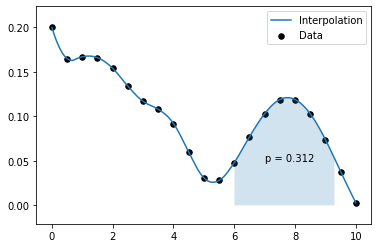

In [8]:
v1, v2 = 6, 9.3
area = get_prob(xs, ys, v1, v2)

plt.scatter(xs, ys, s=30, label="Data", color="black")
plt.plot(x, y3, linestyle="-", label="Interpolation")
plt.fill_between(x, 0, y3, where=(x>=v1)&(x<=v2), alpha=0.2)
plt.annotate(f"p = {area:.3f}", (7, 0.05))
plt.legend();

/Users/pedrojunqueira/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadrature.py:376: RuntimeWarning: invalid value encountered in true_divide
  h0divh1 = h0 / h1
/Users/pedrojunqueira/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadrature.py:378: RuntimeWarning: invalid value encountered in true_divide
  y[slice1]*hsum*hsum/hprod +


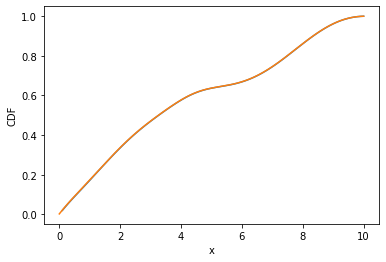

In [7]:
x_new = np.linspace(min(xs), max(xs), 100)
cdf_new = [get_cdf(xs, ys, i) for i in x_new]
cheap_cdf = y3.cumsum() / y3.sum()

plt.plot(x_new, cdf_new, label="Interpolated CDF")
plt.plot(x, cheap_cdf, label="Super cheap CDF for specific cases")
plt.ylabel("CDF")
plt.xlabel("x");

Note that the CDF method we've implemented here keeps it nice and simple, but it is *slow as hell*.

What we *should* do is to determine the CDF function to high accuracy once and store the result and then we can just interpolate from that. Recauculating it each time is a waste of CPU time. In fact, for the vast majority of applications, the `cumsum()` method should be fine so long as you have an array with enough points in it.